In [38]:
import numpy as np
def model_I(t, y, tii, tvi, theta, te):
    """
    Model I: Monod kinetics with maintenance.
    Assumes specific growth rate saturates with substrate and includes maintenance loss.
    """
    y1, y2 = y
    u1 = np.interp(t, te, tvi['u1'])
    u2 = np.interp(t, te, tvi['u2'])

    mu_max = theta[0]  # maximum specific growth rate (1/h)
    Ks     = theta[1]  # Monod saturation constant (g/L)
    Yxs    = theta[2]  # biomass yield coefficient (g biomass / g substrate)
    m      = theta[3]  # maintenance coefficient (1/h)

    r = mu_max * y2 / (Ks + y2)  # Monod rate
    dy1dt = (r - u1 - m) * y1
    dy2dt = -(r * y1 / Yxs) + u1 * (u2 - y2)
    return [dy1dt, dy2dt]

theta_I = [0.25, 0.25, 0.88, 0.09]
theta_min_I = [x * 0.8 for x in theta_I]  # 20% below nominal
theta_max_I = [x * 1.2 for x in theta_I]  # 20% above nominal
theta_maxs_I = [hi / nom for hi, nom in zip(theta_max_I, theta_I)]
theta_mins_I = [lo / nom for lo, nom in zip(theta_min_I, theta_I)]

In [39]:
def model_II(t, y, tii, tvi, theta, te):
    """
    Model II: Canoid kinetics.
    Incorporates dependence of growth on both biomass and substrate concentrations.
    """
    y1, y2 = y
    u1 = np.interp(t, te, tvi['u1'])
    u2 = np.interp(t, te, tvi['u2'])

    mu_max     = theta[0]  # maximum specific growth rate (1/h)
    Ks_biomass = theta[1]  # saturation constant influenced by biomass (L/g)
    Yxs        = theta[2]  # biomass yield coefficient
    m          = theta[3]  # maintenance coefficient

    r = mu_max * y2 / (Ks_biomass * y1 + y2)  # Canoid rate
    dy1dt = (r - u1 - m) * y1
    dy2dt = -(r * y1 / Yxs) + u1 * (u2 - y2)
    return [dy1dt, dy2dt]

theta_II = [0.24987, 0.00912, 0.94194, 0.10154]
theta_min_II = [x * 0.8 for x in theta_II]  # 20% below nominal
theta_max_II = [x * 1.2 for x in theta_II]  # 20% above nominal
theta_maxs_II = [hi / nom for hi, nom in zip(theta_max_II, theta_II)]
theta_mins_II = [lo / nom for lo, nom in zip(theta_min_II, theta_II)]

In [40]:
def model_III(t, y, tii, tvi, theta, te):
    """
    Model III: Linear growth kinetics.
    Assumes specific growth rate is linear with substrate.
    """
    y1, y2 = y
    u1 = np.interp(t, te, tvi['u1'])
    u2 = np.interp(t, te, tvi['u2'])

    a   = theta[0]  # linear rate coefficient (1/h·(g/L))
    Yxs = theta[1]  # biomass yield
    m   = theta[2]  # maintenance coefficient

    r = a * y2
    dy1dt = (r - u1 - m) * y1
    dy2dt = -(r * y1 / Yxs) + u1 * (u2 - y2)
    return [dy1dt, dy2dt]

theta_III = [0.02636, 0.68145, 0.03381]
theta_min_III = [x * 0.8 for x in theta_III]  # 20% below nominal
theta_max_III = [x * 1.2 for x in theta_III]  # 20% above nominal
theta_maxs_III = [hi / nom for hi, nom in zip(theta_max_III, theta_III)]
theta_mins_III = [lo / nom for lo, nom in zip(theta_min_III, theta_III)]

In [41]:
def model_IV(t, y, tii, tvi, theta, te):
    """
    Model IV: Monod kinetics without maintenance.
    Simplified version of Model I, excluding the maintenance term.
    """
    y1, y2 = y
    u1 = np.interp(t, te, tvi['u1'])
    u2 = np.interp(t, te, tvi['u2'])

    mu_max = theta[0]  # max specific growth rate
    Ks     = theta[1]  # Monod constant
    Yxs    = theta[2]  # yield

    r = mu_max * y2 / (Ks + y2)
    dy1dt = (r - u1) * y1
    dy2dt = -(r * y1 / Yxs) + u1 * (u2 - y2)
    return [dy1dt, dy2dt]

theta_IV = [0.15270, 0.40575, 0.47529]
theta_min_IV = [x * 0.8 for x in theta_IV]  # 20% below nominal
theta_max_IV = [x * 1.2 for x in theta_IV]  # 20% above nominal
theta_maxs_IV = [hi / nom for hi, nom in zip(theta_max_IV, theta_IV)]
theta_mins_IV = [lo / nom for lo, nom in zip(theta_min_IV, theta_IV)]

In [42]:
system = {
    'tvi': {  # Time-variant input variables (models input: tvi), each key is a symbol nad key in tvi as well
        'u1': {  # Temperature (K)
            'stps': 3,  # Number of switching times in CVPs (vector parametrisation resolution in time dimension):
            # Must be a positive integer > 1. swps-1 is the number of steps
            'const': 'rel',  # Constraint type: relative state of signal levels in CVPs
            # 'rel' (relative) ensures relaxation, 'dec' (decreasing) ensures decreasing signal levels, 'inc' (increasing) ensures increasing signal levels
            'max': 0.2,  # Maximum allowable signal level, des_opt space upper bound
            'min': 0.05,  # Minimum allowable signal level, des_opt space lower bound
            'cvp': 'CPF',  # Design CVP method (CPF - constant profile, LPF - linear profile)
            'offl': 0.01,  # minimum allowed perturbation of signal (ratio)
            'offt': 1  # minimum allowed perturbation of time (ratio)
        },
        'u2': {  # Pressure (bar)
            'stps': 3,
            'const': 'rel',
            'max': 35,
            'min': 5,
            'cvp': 'LPF',
            'offl': 1,
            'offt': 1
        }
    },
    'tvo': {  # Time-variant output variables (responses, measured or unmeasured)
        'y1': {  # response variable, here carbonation efficiency
            'init': 'variable',  # Initial value for the response variable, it can be a value, or 'variable' for case it is a des_opt decision (time-invariant input variable)
            'meas': True,  # Flag indicating if this variable is directly measurable, if False, it is a virtual output
            'sp': 10,  # the amound of samples per each round (run)
            'unc': 0.05,  # amount of noise (standard deviation) in the measurement, in case of insilico, this is used for simulating a normal distribution of noise to measurement (only measurement)
            'offt': 1,  # minimum allowed perturbation of sampling times (ratio)
            'samp_s': 1,  # Matching criterion for models prediction and data alignment
            'samp_f': [0, 40],  # fixed sampling times
        },
        'y2': {  # response variable, here carbonation efficiency
            'init': 0.01,
            # Initial value for the response variable, it can be a value, or 'variable' for case it is a des_opt decision (time-invariant input variable)
            'meas': True,
            # Flag indicating if this variable is directly measurable, if False, it is a virtual output
            'sp': 10,  # the amound of samples per each round (run)
            'unc': 0.05,
            # amount of noise (standard deviation) in the measurement, in case of insilico, this is used for simulating a normal distribution of noise to measurement (only measurement)
            'offt': 1,  # minimum allowed perturbation of sampling times (ratio)
            'samp_s': 1,  # Matching criterion for models prediction and data alignment
            'samp_f': [0, 40],  # fixed sampling times
        },
    },
    'tii': {  # Time-invariant input variables (tii)
        'y1_0': {  # 1st symbolic time-invariant control, Density of solid reactant (kg/m³)
            'max': 5.5,  # Maximum allowable signal level, des_opt space upper bound
            'min': 1  # Minimum allowable signal level, des_opt space upper bound
        },
    },
    'tio': {  # Time-invariant output variables (empty here, could hold steady state responses that hold no dependency)
    },
    't_s': [0, 40],  # Time span  (600 s to 10,800 s), duration of numerical perturbations (the rest is precluded from des_opt)
    't_r': 0.02,  # Time resolution (10 s), minimum time steps for the simulation/des_opt/controls
    't_d': 0.2
}

In [43]:
models = { # Settings related to the rival models and their parameters
    'can_m': ['MI', 'MII', 'MIII', 'MIV'],  # Active solvers (rival models) to be used in the experiment
    'krt': {'MI': model_I, 'MII': model_II, 'MIII': model_III, 'MIV': model_IV,},
    # type of the model interface, 'pym' for middoe.krnl_models, 'gpr' for gPAS models, function name for globally defined functions, 'pys' for python standalone scripts
    'creds': {'f20': '@@TTmnoa698', 'f21': '@@TTmnoa698'},
    # credentials for gPAS models, if not needed, leave empty
    'src': {'f20': 'C:/Users/Tadmin/PycharmProjects/tutorialmid1/model_semiconwet.py',
            'f21': 'C:/Users/Tadmin/PycharmProjects/tutorialmid1/model_semiconwet.py'},
    # for now for gPAS readable files, or python standalone scripts

    'theta': { # Theta parameters for each models
        'MI': theta_I,
        'MII': theta_II,
        'MIII': theta_III,
        'MIV': theta_IV,
    },
    't_u': { # Maximum bounds for theta parameters (based on normalized to'f20': theta20mins, 1)
        'MI': theta_maxs_I,
        'MII': theta_maxs_II,
        'MIII': theta_maxs_III,
        'MIV': theta_maxs_IV,
    },
    't_l': { # Minimum bounds for theta parameters (based on normalized to 1)
        'MI': theta_mins_I,
        'MII': theta_mins_II,
        'MIII': theta_mins_III,
        'MIV': theta_mins_IV,
    }
}

In [ ]:
gsa = { # Settings for the Global Sensitivity Analysis (gsa)
    'var_s': False,  # Perform sensitivity analysis for variables
    'par_s': True,  # Perform sensitivity analysis for parameters
    'var_d': False, # feasible space for variables, fload ratio: use as multiplier to nominals uniformly (e.g. 1.1), False: use system defined space
    'par_d': False,   # feasible space for parameters, fload ratio: use as multiplier to nominals uniformly(e.g. 1.1), False: use models defined space
    'samp': 2 ** 6,  # Sampling size for gsa, always 2**n
    'multi': 0.7,  # Perform gsa in parallel
    'tii_n': [1], # Nominal values for the time-invariant variables
    'tvi_n': [0.05, 30], # Nominal values for the time-variant variables
    'plt': True,  # Plot the results
}

In [ ]:
from middoe.sc_sensa import sensa
sobol_results = sensa(gsa, models, system)

In [ ]:
from middoe.log_utils import save_to_jac
save_to_jac(sobol_results, purpose="sensa")

In [ ]:
from middoe.log_utils import load_from_jac, save_to_xlsx

results = load_from_jac()
sensa = results['sensa']
save_to_xlsx(sensa)

In [44]:
insilicos = { # Settings for the insilico data generation
    'tr_m': 'MI', # selected true models (with nominal values)
    'prels': { # classic des_opt settings, sheet name is the round run name, each sheet contains the data for the round, iso space.
        '1': {'u1': 0.05, 'u2': 30, 'y_0': 1},
        '2': {'u1': 0.1, 'u2': 30, 'y_0': 1},
        # '3': {'T': 338.15, 'P': 0.17, 'aps': 350, 'slr': 0.1},
        # '4': {'T': 353.15, 'P': 1, 'rho': 3191, 'cac': 44.93, 'aps': 5.5e-5, 'mld': 36000}
    }
}

In [45]:
from middoe.krnl_expera import expera
expera(system, models, insilicos, design_decisions={}, expr=1)


[✓] In-silico data saved to: C:\Users\Tadmin\PycharmProjects\middoe\tests\monod example\indata.xlsx
[INFO] Model used         : MI
[INFO] Design case        : classic/preliminary
[INFO] Responses simulated:
   - y1         | measurable      | std.dev = 0.05
   - y2         | measurable      | std.dev = 0.05


(WindowsPath('C:/Users/Tadmin/PycharmProjects/middoe/tests/monod example/indata.xlsx'),
       MES_X:y1  MES_Y:y1  MES_X:y2  MES_Y:y2  X:all  y1_0    u1    u2  CVP:u1  \
 0         0.00  5.999121      0.00  0.009668   0.00   5.5  0.05  30.0  no_CVP   
 1         4.44  7.028937      4.44  0.962203   0.02   5.5  0.05  30.0     NaN   
 2         8.88  8.390387      8.88  0.473254   0.04   5.5  0.05  30.0     NaN   
 3        13.34  9.390115     13.34  0.378650   0.06   5.5  0.05  30.0     NaN   
 4        17.78  8.923818     17.78  0.338701   0.08   5.5  0.05  30.0     NaN   
 ...        ...       ...       ...       ...    ...   ...   ...   ...     ...   
 1996       NaN       NaN       NaN       NaN  39.92   5.5  0.05  30.0     NaN   
 1997       NaN       NaN       NaN       NaN  39.94   5.5  0.05  30.0     NaN   
 1998       NaN       NaN       NaN       NaN  39.96   5.5  0.05  30.0     NaN   
 1999       NaN       NaN       NaN       NaN  39.98   5.5  0.05  30.0     NaN   
 2000     

In [46]:
from middoe.krnl_expera import expera
expera(system, models, insilicos, design_decisions={}, expr=2)


[✓] In-silico data saved to: C:\Users\Tadmin\PycharmProjects\middoe\tests\monod example\indata.xlsx
[INFO] Model used         : MI
[INFO] Design case        : classic/preliminary
[INFO] Responses simulated:
   - y1         | measurable      | std.dev = 0.05
   - y2         | measurable      | std.dev = 0.05


(WindowsPath('C:/Users/Tadmin/PycharmProjects/middoe/tests/monod example/indata.xlsx'),
       MES_X:y1   MES_Y:y1  MES_X:y2  MES_Y:y2  X:all  y1_0   u1    u2  CVP:u1  \
 0         0.00   5.530088      0.00  0.010412   0.00   5.5  0.1  30.0  no_CVP   
 1         4.44   6.406111      4.44  5.956632   0.02   5.5  0.1  30.0     NaN   
 2         8.88   8.363167      8.88  7.496546   0.04   5.5  0.1  30.0     NaN   
 3        13.34  10.430059     13.34  6.213239   0.06   5.5  0.1  30.0     NaN   
 4        17.78  12.453069     17.78  4.169136   0.08   5.5  0.1  30.0     NaN   
 ...        ...        ...       ...       ...    ...   ...  ...   ...     ...   
 1996       NaN        NaN       NaN       NaN  39.92   5.5  0.1  30.0     NaN   
 1997       NaN        NaN       NaN       NaN  39.94   5.5  0.1  30.0     NaN   
 1998       NaN        NaN       NaN       NaN  39.96   5.5  0.1  30.0     NaN   
 1999       NaN        NaN       NaN       NaN  39.98   5.5  0.1  30.0     NaN   
 2000     

In [47]:
iden_opt = { # Settings for the parameter estimation process
    'meth': 'Ls',  # optimisation method, 'G': Global Differential Evolution, 'Ls': Local SLSQP, 'Ln': Local Nelder-Mead
    'init': None,   # use 'rand' to have random starting point and use None to start from theta_parameters nominal values (to be avoided in insilico studies)
    'eps': 1e-3,  # perturbation size of parameters in SA FDM method (in a normalized to 1 space)
    #usually 1e-3, or None to perform a mesh independency test, and auto adjustment
    'ob': 'WLS',  #loss function, 'LS': least squares, 'MLE': maximum likelihood, 'Chi': chi-square, 'WLS': weighted least squares
    'c_plt': True, # plot the confidence volumes
    'f_plt': True, # plot the fitting results
    'plt_s': True, # show plots while saving
    'log': True # log the results
}

In [48]:
from middoe.log_utils import  read_excel
data = read_excel('indata')

[INFO] Reading from indata.xlsx


In [49]:
from middoe.iden_parmest import parmest
resultpr = parmest(system, models, iden_opt, data)

Objective function: 'WLS'| model 'MI' | CPU time 0.0794 seconds.
Objective function: 'WLS'| model 'MI' | CPU time 0.0789 seconds.
Objective function: 'WLS'| model 'MI' | CPU time 0.0787 seconds.
Objective function: 'WLS'| model 'MI' | CPU time 0.0945 seconds.
Objective function: 'WLS'| model 'MI' | CPU time 0.0794 seconds.
Objective function: 'WLS'| model 'MI' | CPU time 0.1258 seconds.
Objective function: 'WLS'| model 'MI' | CPU time 0.0949 seconds.
Objective function: 'WLS'| model 'MI' | CPU time 0.0788 seconds.
Objective function: 'WLS'| model 'MI' | CPU time 0.0948 seconds.
Objective function: 'WLS'| model 'MI' | CPU time 0.0893 seconds.
Objective function: 'WLS'| model 'MI' | CPU time 0.0791 seconds.
Objective function: 'WLS'| model 'MI' | CPU time 0.0948 seconds.
Objective function: 'WLS'| model 'MI' | CPU time 0.0952 seconds.
Objective function: 'WLS'| model 'MI' | CPU time 0.0949 seconds.
Objective function: 'WLS'| model 'MI' | CPU time 0.0926 seconds.
Objective function: 'WLS'

In [50]:
from middoe.iden_uncert import uncert
uncert_results = uncert(data, resultpr, system, models, iden_opt)
resultun = uncert_results['results']
theta_parameters = uncert_results['theta_parameters']
solver_parameters = uncert_results['solver_parameters']
scaled_params = uncert_results['scaled_params']
obs = uncert_results['obs']


Estimated parameters of MI: [0.24608162985959872, 0.270702049263034, 0.8666564447607011, 0.08457755553028694]
True parameters of MI: [0.25, 0.25, 0.88, 0.09]
LS objective function value for MI: 0.9919693422341688
T-values of model MI: [14.98084753  9.94535465 11.26505456  5.61733106]
P-value of model:MI is 99.16863436747009 for model discrimination
R2 values for responses in model MI:
  y1: 0.9833
  y2: 0.9952
Estimated parameters of MII: [0.24987, 0.00912, 0.94194, 0.10154]
True parameters of MII: [0.24987, 0.00912, 0.94194, 0.10154]
LS objective function value for MII: 0.7764487034610115
T-values of model MII: [2.41355804 1.25936343 1.93309454 1.04947496]
P-value of model:MII is 0.3522234425057053 for model discrimination
R2 values for responses in model MII:
  y1: 0.9710
  y2: 0.9647
Estimated parameters of MIII: [0.02636, 0.68145, 0.03381]
True parameters of MIII: [0.02636, 0.68145, 0.03381]
LS objective function value for MIII: -0.09538675065880442
T-values of model MIII: [1.27451

In [ ]:
from middoe.sc_estima import estima
j = 2
ranking, k_optimal_value, rCC_values, J_k_values = estima(resultun, system, models, iden_opt, j, data)

C:\Users\Tadmin\PycharmProjects\middoe\middoe\iden_utils.py:531: RuntimeWarning: invalid value encountered in sqrt
  width, height = 2 * np.sqrt(vals)


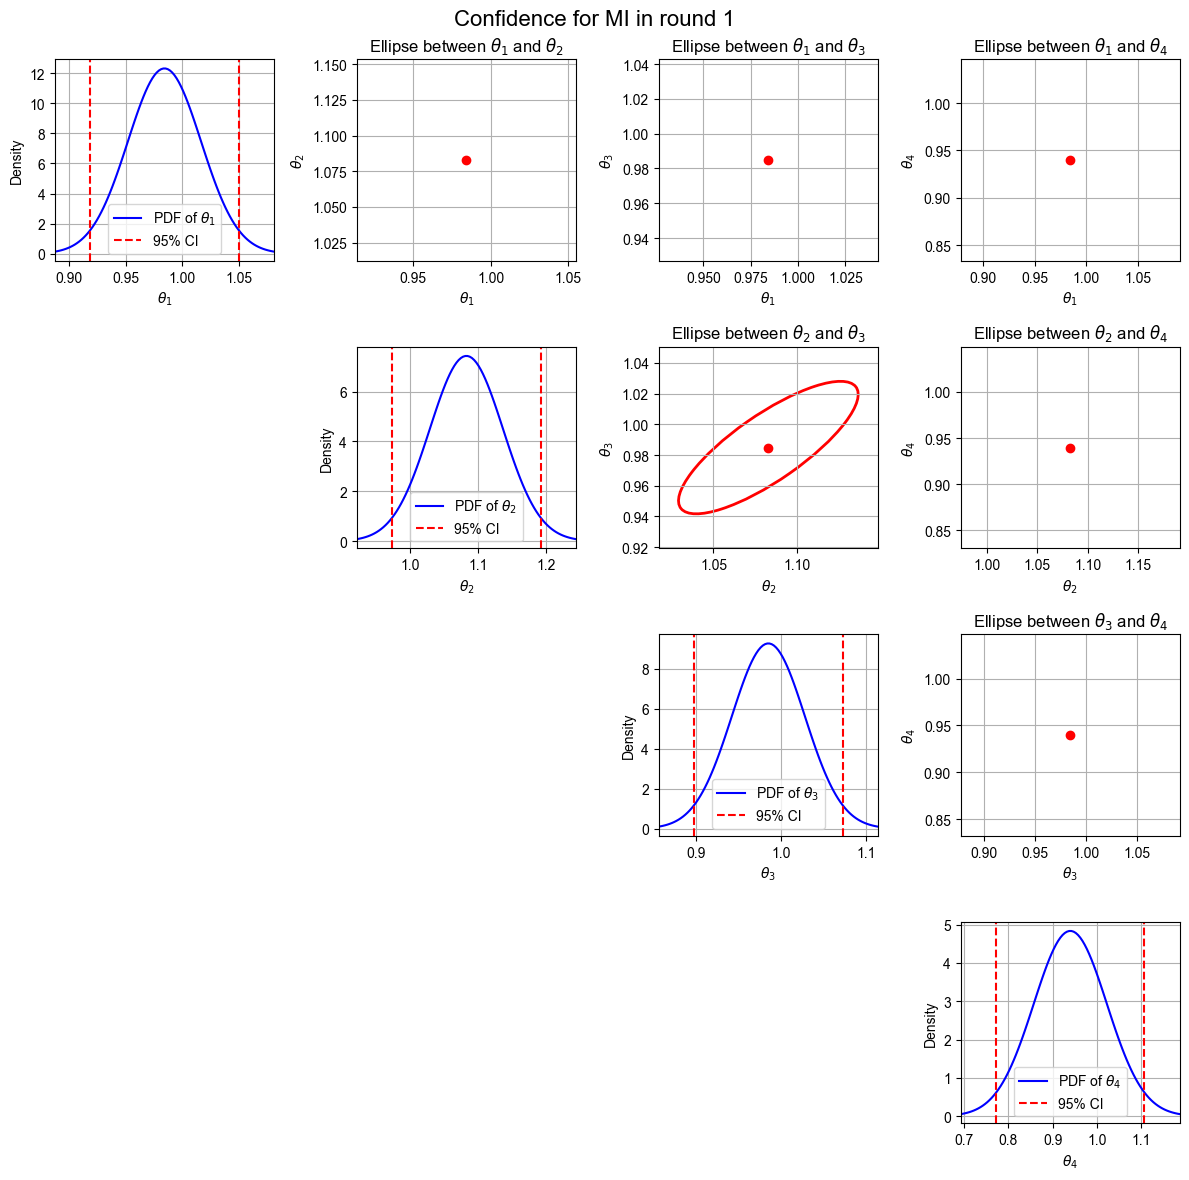

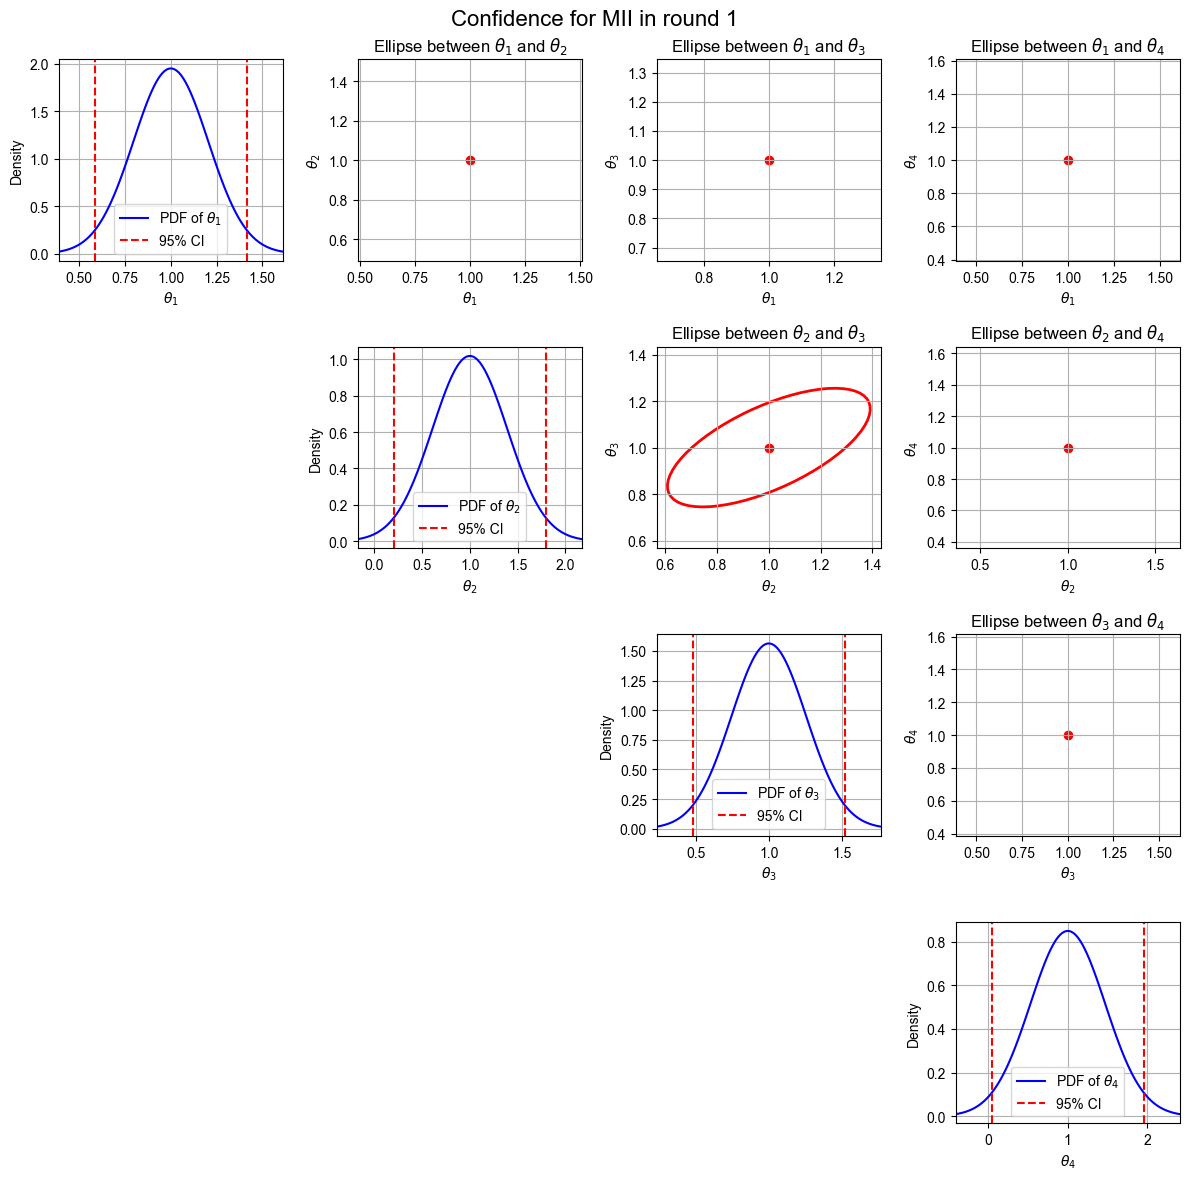

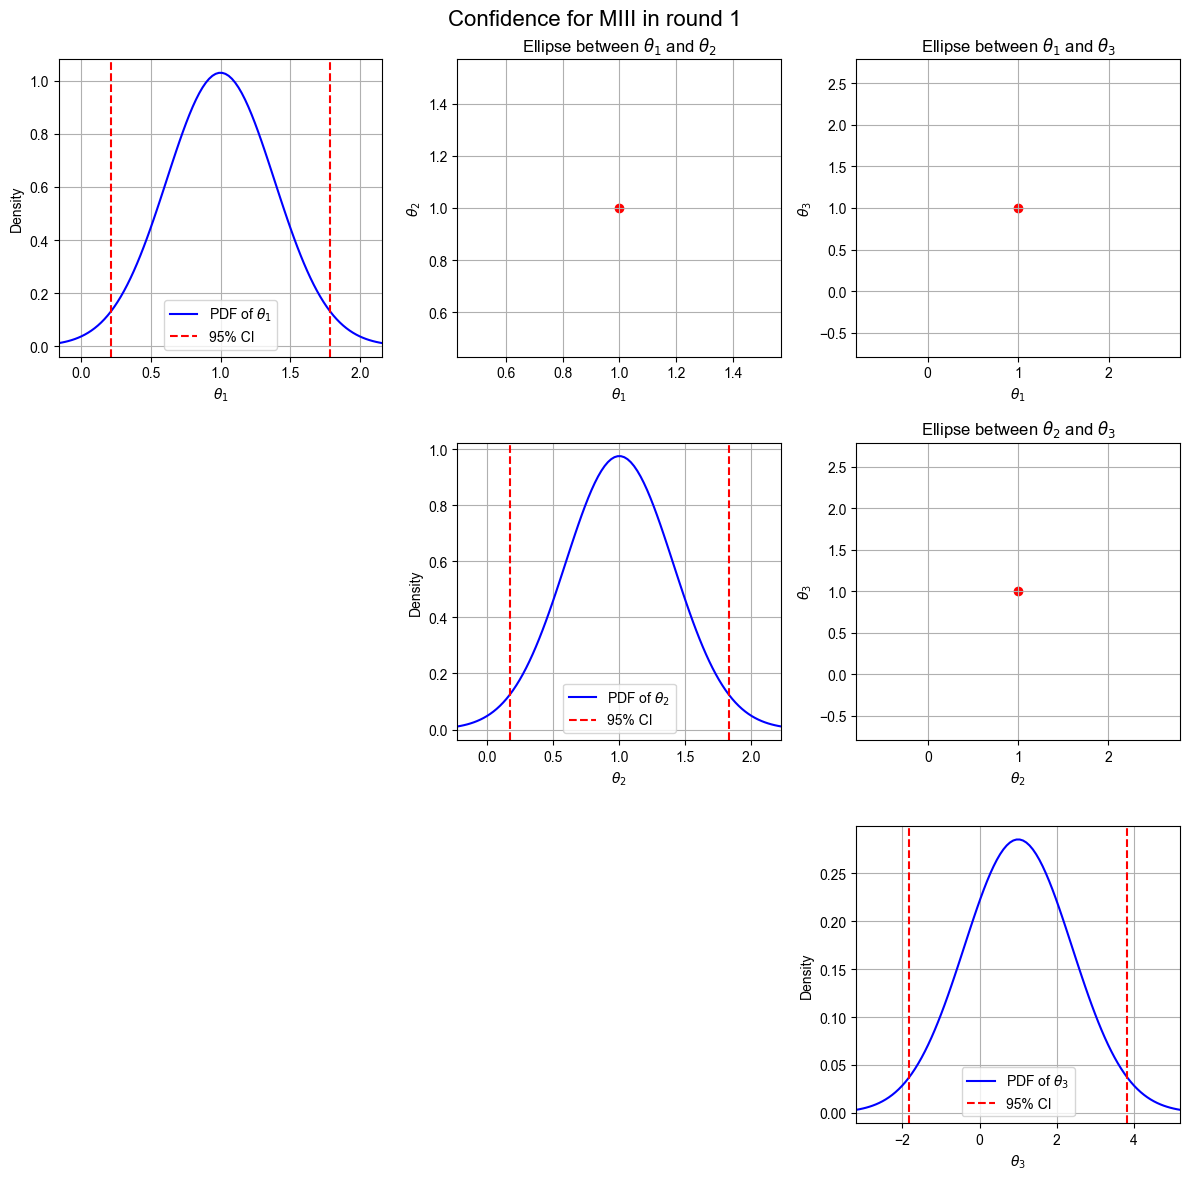

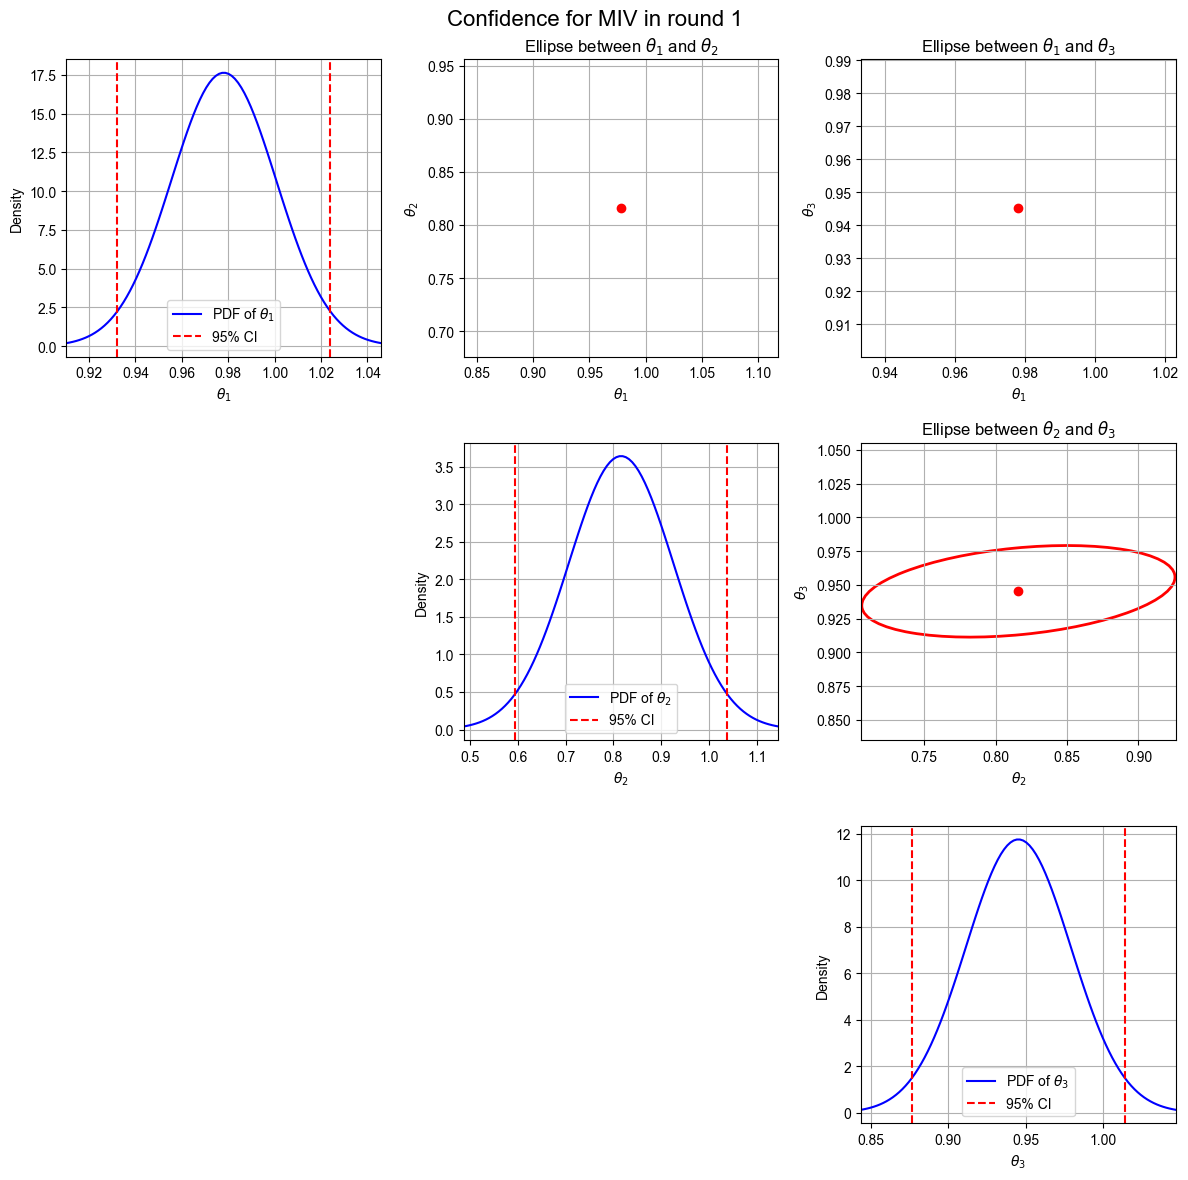

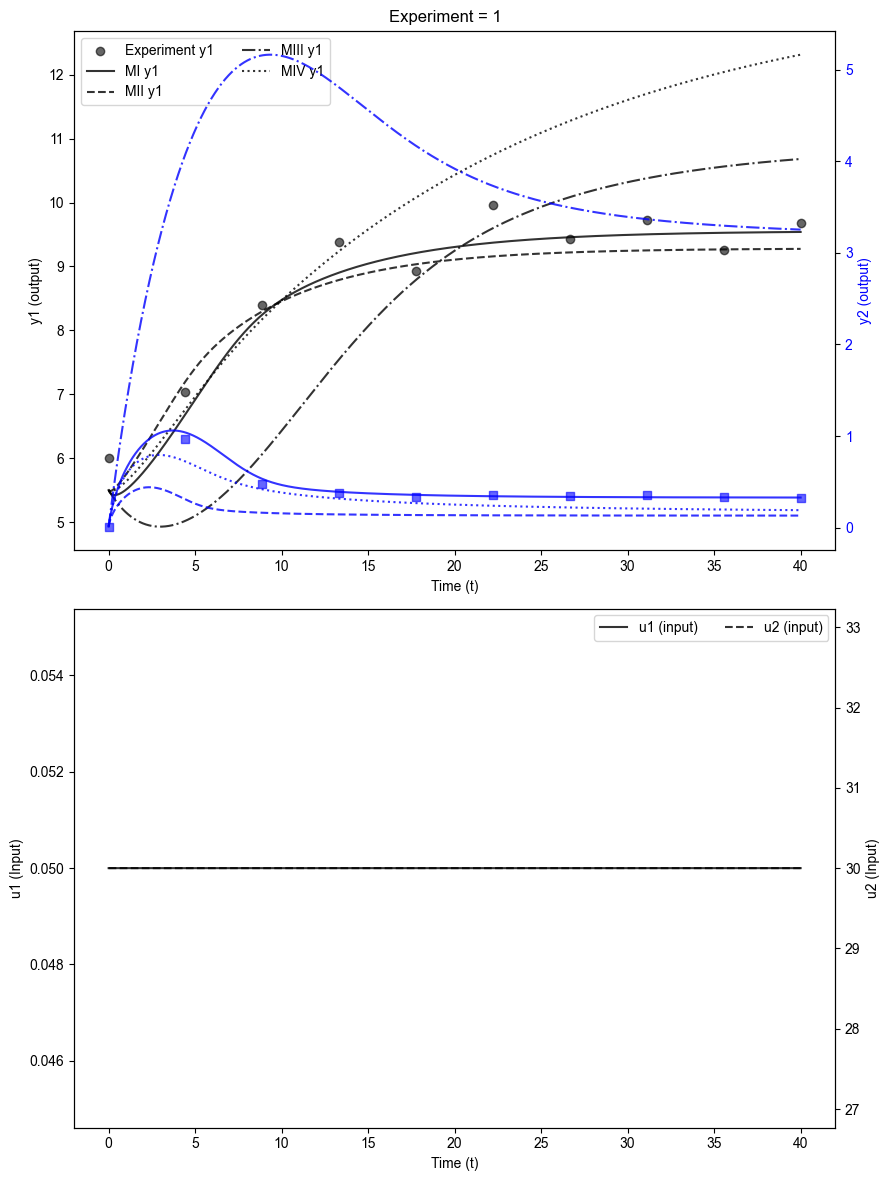

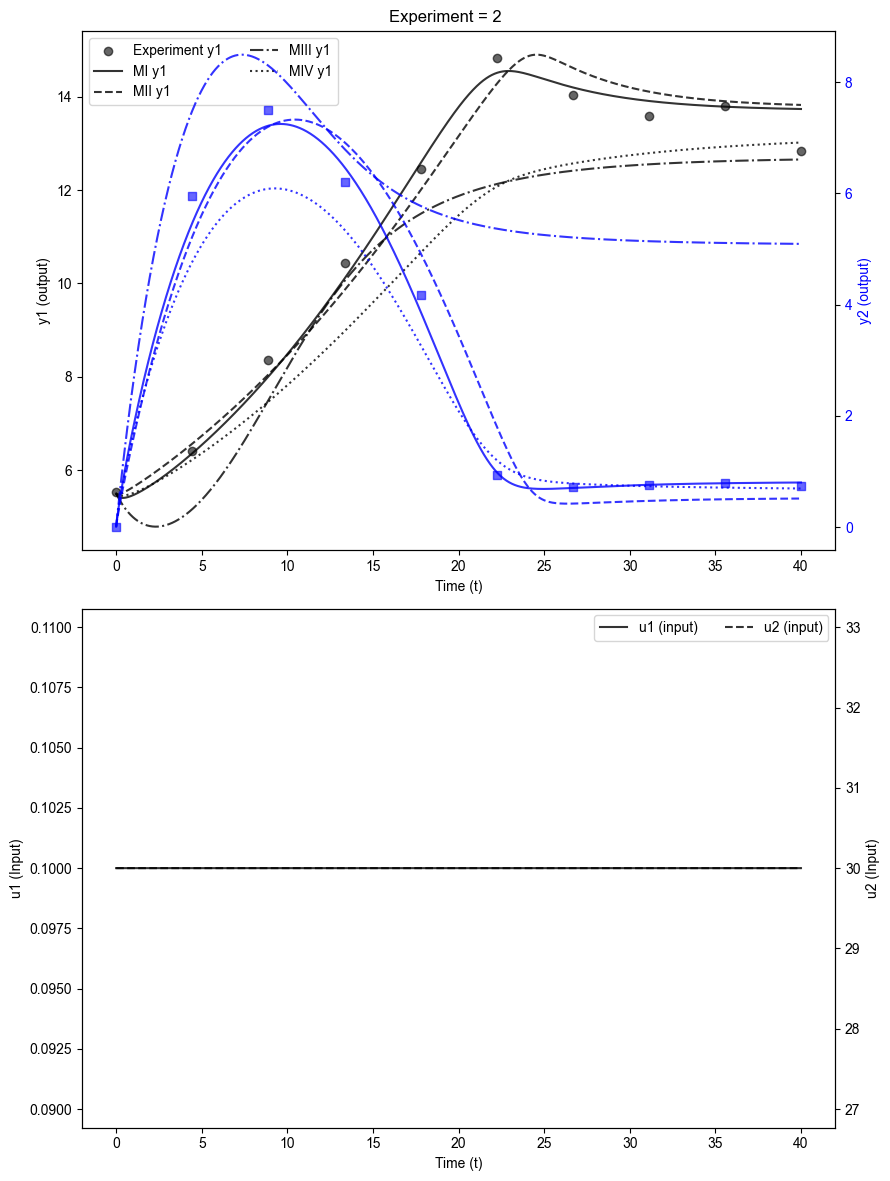

reference t value for model MI and round 1: 2.0280940009804502
estimated t values for model MI and round 1: [14.98084753  9.94535465 11.26505456  5.61733106]
P-value for model MI and round 1: 99.16863436747009
eps for model MI and round 1: 0.001
reference t value for model MII and round 1: 2.0280940009804502
estimated t values for model MII and round 1: [2.41355804 1.25936343 1.93309454 1.04947496]
P-value for model MII and round 1: 0.3522234425057053
eps for model MII and round 1: 0.001
reference t value for model MIII and round 1: 2.0261924630291093
estimated t values for model MIII and round 1: [1.27451031 1.20734686 0.35308002]
P-value for model MIII and round 1: 0.004952998056852885
eps for model MIII and round 1: 0.001
reference t value for model MIV and round 1: 2.0261924630291093
estimated t values for model MIV and round 1: [21.34666986  3.67578358 13.75552683]
P-value for model MIV and round 1: 0.47418919196736625
eps for model MIV and round 1: 0.001



{'MI': np.float64(2.0280940009804502),
 'MII': np.float64(2.0280940009804502),
 'MIII': np.float64(2.0261924630291093),
 'MIV': np.float64(2.0261924630291093)}

In [51]:
from middoe.log_utils import  read_excel, save_rounds
round_data={}
round = 1
save_rounds(round, resultun, theta_parameters, 'preliminary', round_data, models, scaled_params,iden_opt,solver_parameters, obs, data, system)

In [53]:
des_opt = { # Design settings for the experiment
    'eps': 1e-3, #perturbation size of parameters in SA FDM method (in a normalized to 1 space)
    'md_ob': 'HR',     # MD optimality criterion, 'HR': Hunter and Reiner, 'BFF': Buzzi-Ferraris and Forzatti
    'pp_ob': 'E',  # PP optimality criterion, 'D', 'A', 'E', 'ME'
    'plt': True,  # Plot the results
    'itr': {
        'pps': 50, # population size
        'maxmd': 5, # maximum number of MD runs
        'tolmd': 1, # tolerance for MD optimization
        'maxpp':20 ,# maximum number of PP runs
        'tolpp': 1, # tolerance for PP optimization
    }
}

In [ ]:

from middoe.des_md import mbdoe_md
designs = mbdoe_md(des_opt, system, models, round=2, num_parallel_runs=10)

In [ ]:
expera(system, models, insilicos, designs, expr=3, swps=designs['swps'])

In [ ]:
data = read_excel('indata')

In [ ]:
resultpr = parmest(system, models, iden_opt, data)

In [ ]:
uncert_results = uncert(data, resultpr, system, models, iden_opt)
resultun = uncert_results['results']
theta_parameters = uncert_results['theta_parameters']
solver_parameters = uncert_results['solver_parameters']
scaled_params = uncert_results['scaled_params']
obs = uncert_results['obs']

In [ ]:
round = 2
save_rounds(round, resultun, theta_parameters, 'MBDOE_MD', round_data, models, scaled_params, iden_opt,
            solver_parameters, obs, data, system)

In [ ]:
models['can_m'].remove('f21')

In [ ]:
from middoe.des_pp import mbdoe_pp
designs2 = mbdoe_pp(des_opt, system, models, round=3, num_parallel_runs=20)

In [ ]:
expera(system, models, insilicos, designs2, expr=4, swps=designs['swps'])

In [ ]:
data = read_excel('indata')

In [ ]:
resultpr = parmest(system, models, iden_opt, data)

In [ ]:
uncert_results = uncert(data, resultpr, system, models, iden_opt)
resultun = uncert_results['results']
theta_parameters = uncert_results['theta_parameters']
solver_parameters = uncert_results['solver_parameters']
scaled_params = uncert_results['scaled_params']
obs = uncert_results['obs']

In [ ]:
round = 3
save_rounds(round, resultun, theta_parameters, 'MBDOE_PP', round_data, models, scaled_params, iden_opt,
            solver_parameters, obs, data, system)

In [ ]:
save_to_jac(round_data, purpose="iden")


In [ ]:
from middoe.iden_valida import validation
R2_prd, R2_val, parameters = validation(data, system, models, iden_opt,round_data)

In [ ]:
results = load_from_jac()
iden = results['iden']

In [ ]:
from middoe.iden_utils import run_postprocessing
run_postprocessing(
    round_data=results['iden'],
    solvers=['f20', 'f21'],
    selected_rounds=[ 1, 2, 3],
    plot_global_p_and_t=True,
    plot_confidence_spaces=True,
    plot_p_and_t_tests=True,
    export_excel_reports=True,
    plot_estimability=True
)